In [1]:
import keras
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam, RMSprop, SGD
from keras import backend as K


In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'Polyp_copy/train'
validation_data_dir = 'Polyp_copy/validation'

# Image generation 
train_datagen = ImageDataGenerator(
     rescale=1./255
#       rotation_range=45,
#       width_shift_range=0.3,
#      height_shift_range=0.3,
#       horizontal_flip=True,
#      fill_mode='nearest'
)
 # Image generation 

validation_datagen = ImageDataGenerator(
     rescale=1./255
#      rotation_range=45,
#       width_shift_range=0.3,
#     height_shift_range=0.3,
#       horizontal_flip=True,
#      fill_mode='nearest'
)
 
# set our batch size
batch_size = 25

 # Standardize image size (Resize to 64 x 64 x 3)
img_rows, img_cols = 64, 64 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [3]:
# training data
X_train, y_train = next(train_generator)
for i in range((300//batch_size) - 1):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

(300, 64, 64, 3) (300, 2)


In [4]:
# validation data
X_valid, y_valid = next(validation_generator)
for i in range((100//batch_size) - 1):
    img, label = next(validation_generator)
    X_valid = np.append(X_valid, img, axis=0 )
    y_valid = np.append(y_valid, label, axis=0)
print(X_valid.shape, y_valid.shape)

(100, 64, 64, 3) (100, 2)


In [5]:
# Reshape the training and validation data
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_valid.reshape((len(X_valid), np.prod(X_valid.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(300, 12288)
(100, 12288)


In [12]:
sp = 0.05
b_val = 3;#Controls the acitvity of the hidden layer nodes
original_dim = x_train.shape[1]
encoding_dim = 6000 
# input_img = keras.layers.Input(shape=(784,))
lambda_val = 0.002 #Weight decay , refer : https://stackoverflow.com/questions/44495698/keras-difference-between-kernel-and-activity-regularizers
#Custom Regularizer function
def sparse_reg(activ_matrix):
    p = 0.05
    beta = 3
    p_hat = K.mean(activ_matrix) # average over the batch samples
    print("p_hat = ",p_hat)
    #KLD = p*(K.log(p)-K.log(p_hat)) + (1-p)*(K.log(1-p)-K.log(1-p_hat))
    KLD = p*(K.log(p/p_hat)) + (1-p)*(K.log(1-p/1-p_hat))
    print("KLD = ", KLD)
    return beta * K.sum(KLD) # sum over the layer units

In [27]:
original_dim = x_train.shape[1]
latent_dim = 64

input_img = keras.Input(shape=(x_train.shape[1],))
encoded = layers.Dense(6000, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(lambda_val/2),activity_regularizer=sparse_reg)(input_img)
encoded = layers.Dense(1500, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(lambda_val/2),activity_regularizer=sparse_reg)(encoded)

# Decoder
decoded = layers.Dense(6000, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(lambda_val/2),activity_regularizer=sparse_reg)(encoded)
decoded = layers.Dense(x_train.shape[1], activation='sigmoid', kernel_regularizer=keras.regularizers.l2(lambda_val/2),activity_regularizer=sparse_reg)(decoded)


vae = keras.Model(input_img, decoded)


p_hat =  Tensor("dense_4/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("dense_4/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("dense_5/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("dense_5/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("dense_6/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("dense_6/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("dense_7/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("dense_7/ActivityRegularizer/add:0", shape=(), dtype=float32)


In [29]:
vae.compile(optimizer='SGD', loss = 'mse')

In [15]:
# For an autoencoder with only one hidden layer, this allows you to
# separate the encoder and decoder into two models. 

encoder = keras.Model(input_img, encoded) #map input image to decoded image
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = vae.layers[-1] #Gets the last layer
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

p_hat =  Tensor("dense_3/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("dense_3/ActivityRegularizer/add:0", shape=(), dtype=float32)


In [30]:
# Train the autoencoder - currently 400 epochs
r = vae.fit(x_train, x_train,
                epochs=400,
                batch_size=20,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/400
p_hat =  Tensor("model_5/dense_4/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_4/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_5/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_5/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_6/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_6/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_7/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_7/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_4/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_4/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_5/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_5/ActivityRegular

2023-04-30 17:52:55.485950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 21.8199p_hat =  Tensor("model_5/dense_4/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_4/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_5/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_5/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_6/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_6/ActivityRegularizer/add:0", shape=(), dtype=float32)
p_hat =  Tensor("model_5/dense_7/ActivityRegularizer/Mean:0", shape=(), dtype=float32)
KLD =  Tensor("model_5/dense_7/ActivityRegularizer/add:0", shape=(), dtype=float32)


2023-04-30 17:52:58.786299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 208ms/step - loss: 21.8199 - val_loss: 21.8134
Epoch 2/400
15/15 [==============================] - 3s 197ms/step - loss: 21.8050 - val_loss: 21.7986
Epoch 3/400
15/15 [==============================] - 3s 186ms/step - loss: 21.7902 - val_loss: 21.7837
Epoch 4/400
15/15 [==============================] - 3s 200ms/step - loss: 21.7754 - val_loss: 21.7689
Epoch 5/400
15/15 [==============================] - 3s 194ms/step - loss: 21.7606 - val_loss: 21.7541
Epoch 6/400
15/15 [==============================] - 3s 216ms/step - loss: 21.7457 - val_loss: 21.7392
Epoch 7/400
15/15 [==============================] - 3s 205ms/step - loss: 21.7308 - val_loss: 21.7244
Epoch 8/400
15/15 [==============================] - 3s 200ms/step - loss: 21.7160 - val_loss: 21.7095
Epoch 9/400
15/15 [==============================] - 3s 214ms/step - loss: 21.7011 - val_loss: 21.6946
Epoch 10/400
15/15 [==============================] - 3s 217ms/step - loss: 21.6862 -

Epoch 80/400
15/15 [==============================] - 3s 185ms/step - loss: 20.5389 - val_loss: 20.5303
Epoch 81/400
15/15 [==============================] - 3s 186ms/step - loss: 20.5178 - val_loss: 20.5090
Epoch 82/400
15/15 [==============================] - 3s 185ms/step - loss: 20.4963 - val_loss: 20.4873
Epoch 83/400
15/15 [==============================] - 3s 184ms/step - loss: 20.4742 - val_loss: 20.4650
Epoch 84/400
15/15 [==============================] - 3s 186ms/step - loss: 20.4516 - val_loss: 20.4420
Epoch 85/400
15/15 [==============================] - 3s 185ms/step - loss: 20.4282 - val_loss: 20.4184
Epoch 86/400
15/15 [==============================] - 3s 187ms/step - loss: 20.4041 - val_loss: 20.3939
Epoch 87/400
15/15 [==============================] - 3s 187ms/step - loss: 20.3790 - val_loss: 20.3683
Epoch 88/400
15/15 [==============================] - 3s 187ms/step - loss: 20.3528 - val_loss: 20.3415
Epoch 89/400
15/15 [==============================] - 3s 185ms/s

15/15 [==============================] - 3s 185ms/step - loss: 19.6017 - val_loss: 19.5948
Epoch 161/400
15/15 [==============================] - 3s 185ms/step - loss: 19.5841 - val_loss: 19.5772
Epoch 162/400
15/15 [==============================] - 3s 186ms/step - loss: 19.5665 - val_loss: 19.5595
Epoch 163/400
15/15 [==============================] - 3s 186ms/step - loss: 19.5486 - val_loss: 19.5416
Epoch 164/400
15/15 [==============================] - 3s 195ms/step - loss: 19.5306 - val_loss: 19.5235
Epoch 165/400
15/15 [==============================] - 3s 191ms/step - loss: 19.5124 - val_loss: 19.5052
Epoch 166/400
15/15 [==============================] - 3s 185ms/step - loss: 19.4941 - val_loss: 19.4868
Epoch 167/400
15/15 [==============================] - 3s 186ms/step - loss: 19.4755 - val_loss: 19.4681
Epoch 168/400
15/15 [==============================] - 3s 184ms/step - loss: 19.4566 - val_loss: 19.4492
Epoch 169/400
15/15 [==============================] - 3s 187ms/step 

15/15 [==============================] - 3s 187ms/step - loss: nan - val_loss: nan
Epoch 243/400
15/15 [==============================] - 3s 189ms/step - loss: nan - val_loss: nan
Epoch 244/400
15/15 [==============================] - 3s 186ms/step - loss: nan - val_loss: nan
Epoch 245/400
15/15 [==============================] - 3s 187ms/step - loss: nan - val_loss: nan
Epoch 246/400
15/15 [==============================] - 3s 187ms/step - loss: nan - val_loss: nan
Epoch 247/400
15/15 [==============================] - 3s 186ms/step - loss: nan - val_loss: 26.1239
Epoch 248/400
15/15 [==============================] - 3s 188ms/step - loss: 26.1150 - val_loss: 26.1080
Epoch 249/400
15/15 [==============================] - 3s 188ms/step - loss: 26.0991 - val_loss: 26.0921
Epoch 250/400
15/15 [==============================] - 3s 187ms/step - loss: 26.0832 - val_loss: 26.0762
Epoch 251/400
15/15 [==============================] - 3s 186ms/step - loss: 26.0673 - val_loss: 26.0603
Epoch 25

15/15 [==============================] - 3s 187ms/step - loss: 24.9940 - val_loss: 24.9873
Epoch 321/400
15/15 [==============================] - 3s 185ms/step - loss: 24.9788 - val_loss: 24.9721
Epoch 322/400
15/15 [==============================] - 3s 186ms/step - loss: 24.9636 - val_loss: 24.9569
Epoch 323/400
15/15 [==============================] - 3s 192ms/step - loss: 24.9484 - val_loss: 24.9417
Epoch 324/400
15/15 [==============================] - 3s 185ms/step - loss: 24.9332 - val_loss: 24.9265
Epoch 325/400
15/15 [==============================] - 3s 185ms/step - loss: 24.9180 - val_loss: 24.9114
Epoch 326/400
15/15 [==============================] - 3s 185ms/step - loss: 24.9028 - val_loss: 24.8962
Epoch 327/400
15/15 [==============================] - 3s 185ms/step - loss: 24.8877 - val_loss: 24.8810
Epoch 328/400
15/15 [==============================] - 3s 186ms/step - loss: 24.8725 - val_loss: 24.8659
Epoch 329/400
15/15 [==============================] - 3s 185ms/step 

15/15 [==============================] - 3s 183ms/step - loss: 23.8346 - val_loss: 23.8283
Epoch 399/400
15/15 [==============================] - 3s 184ms/step - loss: 23.8201 - val_loss: 23.8138
Epoch 400/400
15/15 [==============================] - 3s 185ms/step - loss: 23.8056 - val_loss: 23.7993


4/4 [==============================] - 0s 36ms/step


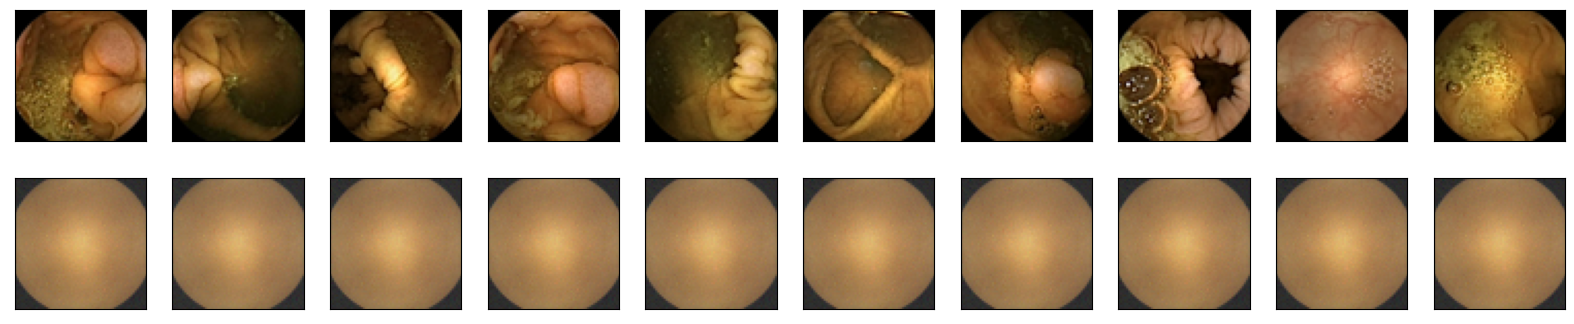

In [22]:
# Right now only works for autoencoder with only one hidden layer
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


# Display the images - original on top and generated below
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



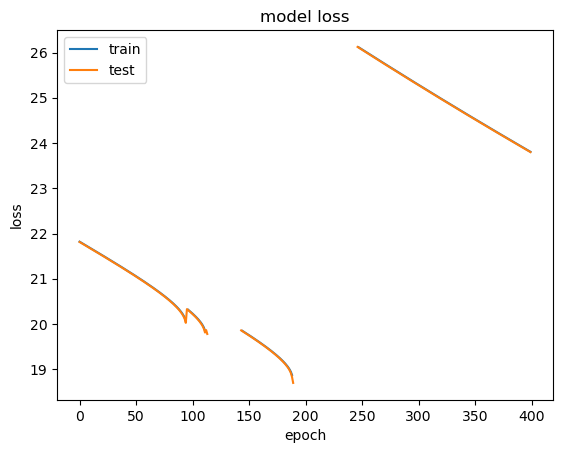

In [34]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# For an autoencoder with more than one hidden layer
images = vae.predict(x_test)

4/4 [==============================] - 0s 77ms/step


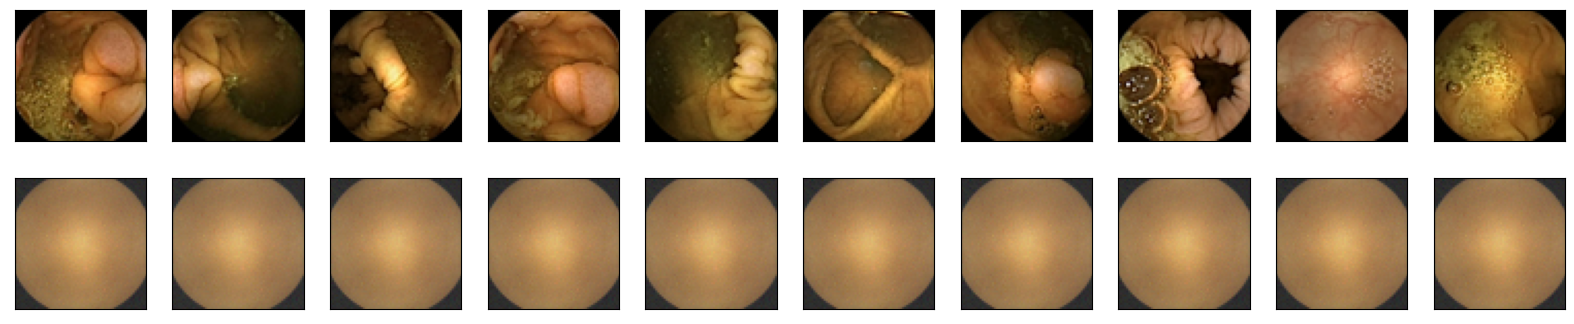

In [36]:
import matplotlib.pyplot as plt

n = 10  # How many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


